In [171]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.impute import SimpleImputer
import librosa
from tqdm import tqdm
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Define the base path
BASE_PATH = "/content/drive/MyDrive/DSL_Winter_Project_2025/"

In [28]:
# Define the core feature columns
CORE_FEATURES = [
    "pitch_mean", "pitch_std", "pitch_iqr",
    "f1_mean", "f2_mean", "f3_mean", "f2_f1_ratio",
    "hnr_mean", "jitter", "shimmer",
    "speech_rate", "pause_duration_std",
    "spectral_flux", "rolloff_25", "rolloff_75",
    "mfcc1_mean", "mfcc1_std", "mfcc2_mean"
]

In [29]:
def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # Pitch dynamics
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitches = pitches[pitches > 0]
        pitch_mean = np.mean(pitches)
        pitch_std = np.std(pitches)
        pitch_iqr = np.subtract(*np.percentile(pitches, [75, 25]))

        # Formants (approximation)
        S = np.abs(librosa.stft(y))
        frequencies = librosa.fft_frequencies(sr=sr)
        formants = [np.mean(frequencies[scipy.signal.find_peaks(frame)[0]][:3]) for frame in S.T[:3]]
        f1_mean, f2_mean, f3_mean = formants + [np.nan] * (3 - len(formants))
        f2_f1_ratio = f2_mean / f1_mean if f1_mean > 0 else np.nan

        # Voice quality
        hnr_mean = librosa.feature.rms(y=y).mean()
        jitter = np.mean(np.abs(np.diff(pitches))) / pitch_mean if pitch_mean > 0 else np.nan
        shimmer = np.std(magnitudes) / np.mean(magnitudes) if np.mean(magnitudes) > 0 else np.nan

        # Temporal features
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        speech_rate = librosa.beat.tempo(onset_envelope=onset_env, sr=sr).mean()
        pause_duration_std = np.std(np.diff(np.where(onset_env < 0.01)[0])) if len(onset_env) > 0 else np.nan

        # Spectral features
        spectral_flux = np.mean(librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.mean))
        rolloff_25 = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.25))
        rolloff_75 = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.75))

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=3)
        mfcc1_mean, mfcc1_std, mfcc2_mean = np.mean(mfccs, axis=1)

        return [
            pitch_mean, pitch_std, pitch_iqr,
            f1_mean, f2_mean, f3_mean, f2_f1_ratio,
            hnr_mean, jitter, shimmer,
            speech_rate, pause_duration_std,
            spectral_flux, rolloff_25, rolloff_75,
            mfcc1_mean, mfcc1_std, mfcc2_mean
        ]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan] * len(CORE_FEATURES)

In [30]:
def process_dataset(dataset_path, output_path):
    data = pd.read_csv(dataset_path)
    audio_features = []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Processing audio files"):
        file_path = os.path.join(BASE_PATH, row['path'])
        audio_features.append(extract_audio_features(file_path))
    features_df = pd.DataFrame(audio_features, columns=CORE_FEATURES)
    enhanced_data = pd.concat([data, features_df], axis=1)
    enhanced_data.to_csv(output_path, index=False)
    print(f"Saved processed dataset to {output_path}")

In [31]:
def main():
    process_dataset(
        os.path.join(BASE_PATH, 'development.csv'),
        os.path.join(BASE_PATH, 'development_with_core_features.csv')
    )
    process_dataset(
        os.path.join(BASE_PATH, 'evaluation.csv'),
        os.path.join(BASE_PATH, 'evaluation_with_core_features.csv')
    )

In [ ]:
if __name__ == "__main__":
    main()

In [172]:
# Load the datasets
development_data = pd.read_csv('/content/drive/MyDrive/DSL_Winter_Project_2025/development_with_core_features.csv')
evaluation_data = pd.read_csv('/content/drive/MyDrive/DSL_Winter_Project_2025/evaluation_with_core_features.csv')

In [173]:
# 1. Check for duplicates
duplicate_count = development_data.duplicated().sum()
print(f"Number of duplicate rows in development_data: {duplicate_count}")

# 2. Check for missing values
missing_summary = development_data.isnull().sum()
print("Missing values in each column:\n", missing_summary)

# 3. Unique values for categorical columns
print("\nUnique genders:", development_data["gender"].unique())
print("Unique ethnicities:", development_data["ethnicity"].unique())

Number of duplicate rows in development_data: 0
Missing values in each column:
 Id                         0
sampling_rate              0
age                        0
gender                     0
ethnicity                  0
mean_pitch                 0
max_pitch                  0
min_pitch                  0
jitter                     0
shimmer                    0
energy                     0
zcr_mean                   0
spectral_centroid_mean     0
tempo                      0
hnr                        0
num_words                  0
num_characters             0
num_pauses                 0
silence_duration           0
path                       0
pitch_mean                 0
pitch_std                  0
pitch_iqr                  0
f1_mean                   11
f2_mean                   11
f3_mean                   11
f2_f1_ratio               11
hnr_mean                   0
jitter.1                   0
shimmer.1                  0
speech_rate                0
pause_duration_std   

In [174]:
# Create a list of the columns we want to impute
cols_to_impute = ["f1_mean", "f2_mean", "f3_mean", "f2_f1_ratio"]

# Create the imputer (using mean)
imputer = SimpleImputer(strategy='mean')

# Fit and transform only on these columns
development_data[cols_to_impute] = imputer.fit_transform(development_data[cols_to_impute])

In [175]:
def parse_tempo(val):
    """
    Converts tempo from string/object (like '[129.19921875]') to float.
    Returns np.nan if parsing fails.
    """
    val_str = str(val).strip("[]")
    try:
        return float(val_str)
    except:
        return np.nan
development_data["tempo"] = development_data["tempo"].apply(parse_tempo)

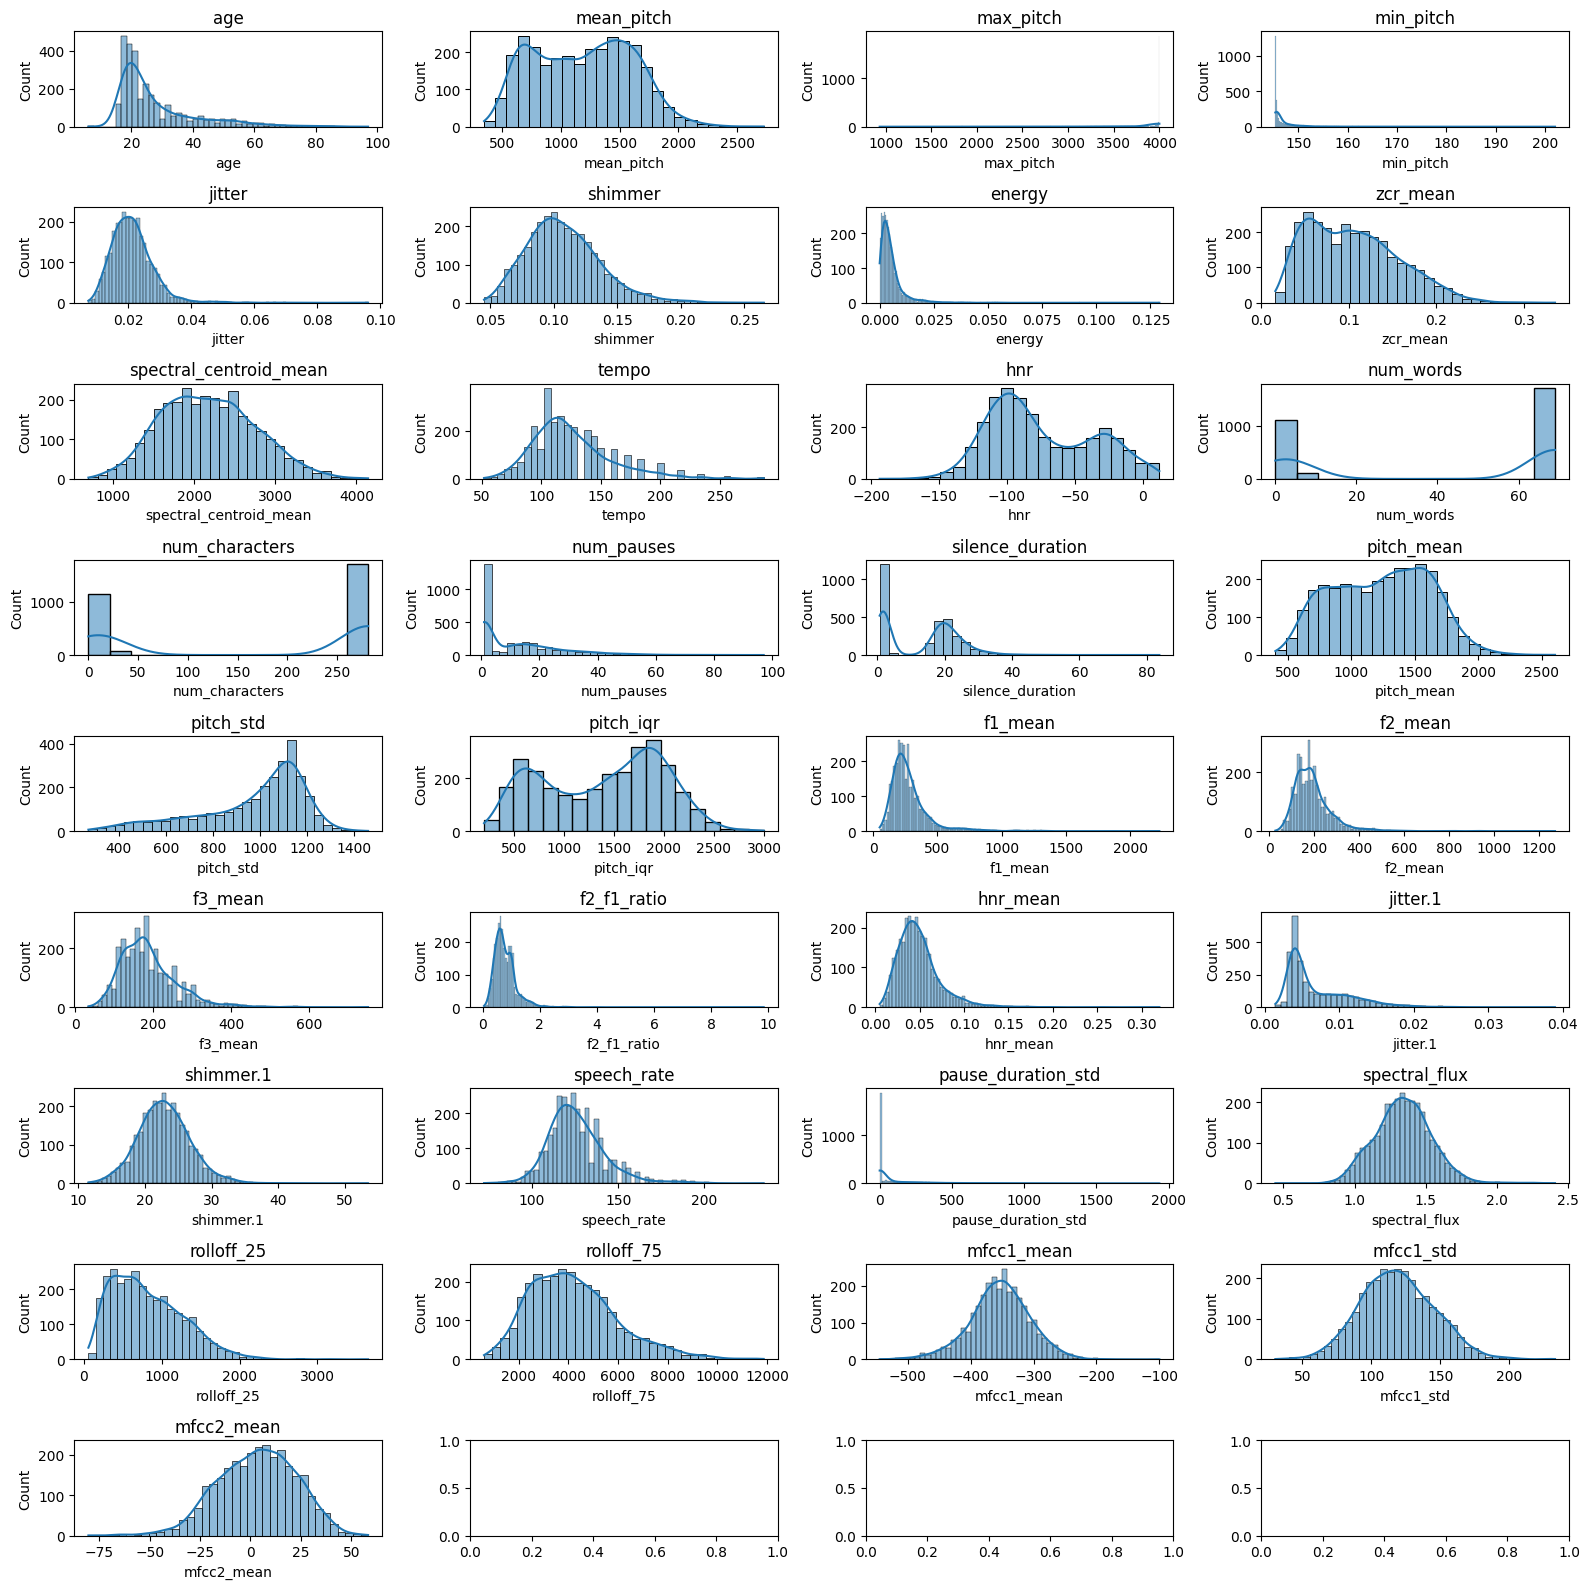

In [176]:
# List numeric columns
numeric_cols = ["age", "mean_pitch", "max_pitch", "min_pitch","jitter","shimmer","energy","zcr_mean","spectral_centroid_mean","tempo","hnr","num_words","num_characters","num_pauses","silence_duration", "pitch_mean", "pitch_std", "pitch_iqr", "f1_mean", "f2_mean", "f3_mean", "f2_f1_ratio", "hnr_mean", "jitter.1", "shimmer.1", "speech_rate", "pause_duration_std", "spectral_flux", "rolloff_25", "rolloff_75", "mfcc1_mean", "mfcc1_std", "mfcc2_mean"
]

# Plot histograms
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if i < len(axes):  # just to avoid index errors if we have more columns than subplots
        sns.histplot(data=development_data, x=col, kde=True, ax=axes[i])
        axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [177]:
# 1. Identify top 1 most frequent ethnicities
top_1 = development_data['ethnicity'].value_counts().nlargest(1).index

# 2. Replace everything not in top_1 with "Other"
development_data['ethnicity'] = development_data['ethnicity'].apply(
    lambda x: x if x in top_1 else "Other"
)

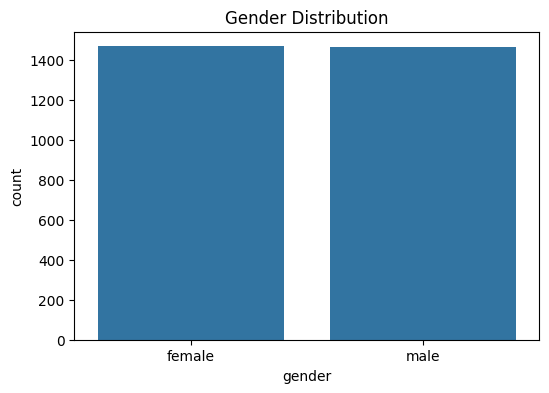

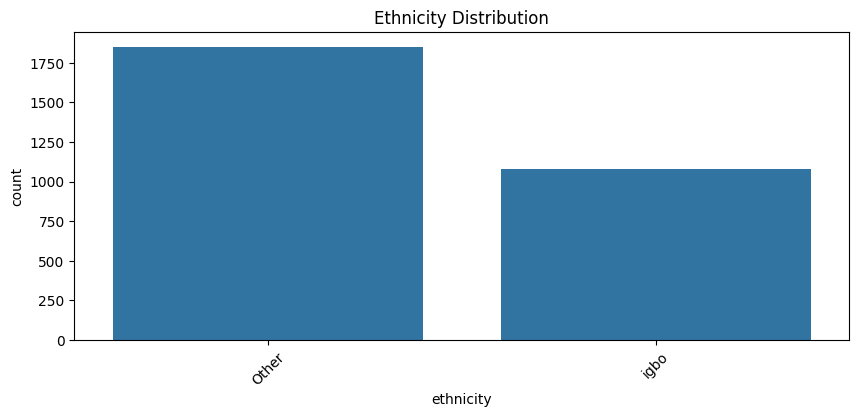

In [178]:
# Countplot for gender
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=development_data)
plt.title("Gender Distribution")
plt.show()

# Countplot for ethnicity
plt.figure(figsize=(10,4))
sns.countplot(x="ethnicity", data=development_data,
              order=development_data["ethnicity"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Ethnicity Distribution")
plt.show()

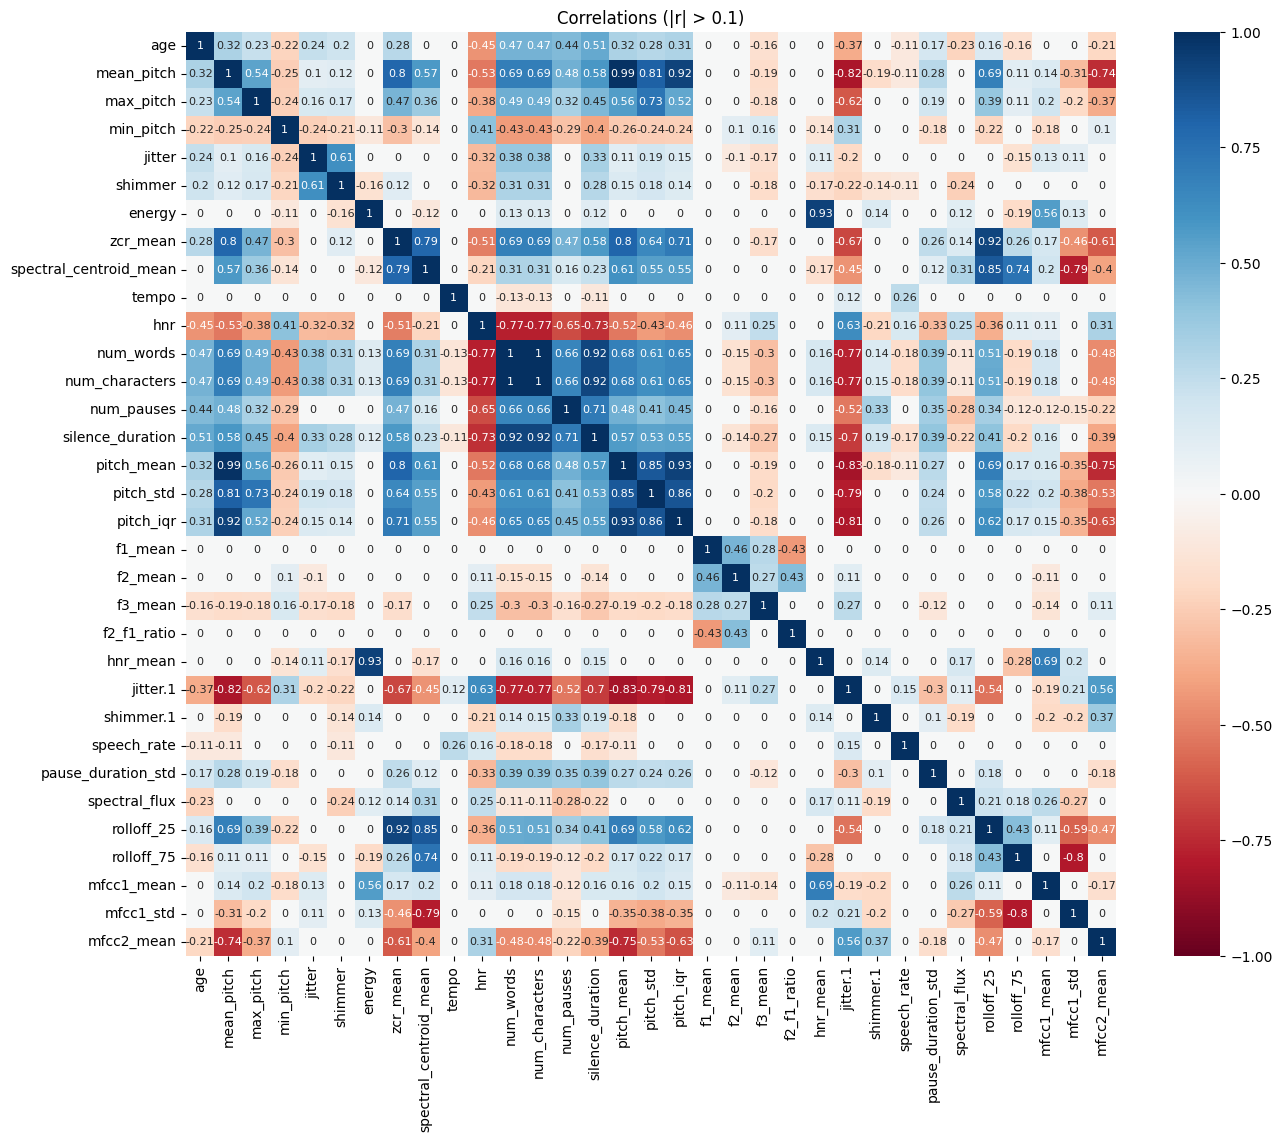

In [191]:
# Correlation matrix (numeric only)
corr_matrix = development_data[numeric_cols].corr(method="pearson")
threshold = 0.1
corr_filtered = corr_matrix[corr_matrix.abs() > threshold].fillna(0)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_filtered,
            annot=True,
            annot_kws={"size": 8},
            cmap="RdBu",
            vmin=-1,
            vmax=1,
            center=0)
plt.title(f"Correlations (|r| > {threshold})")
plt.show()

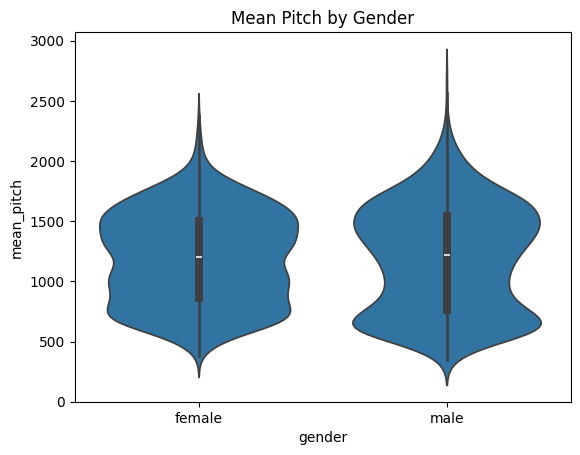

In [180]:
sns.violinplot(data=development_data, x="gender", y="mean_pitch")
plt.title("Mean Pitch by Gender")
plt.show()

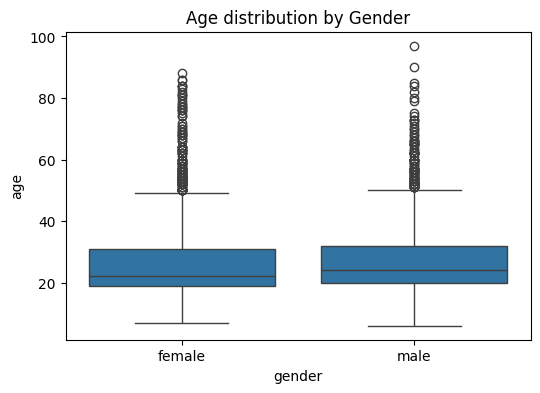

In [181]:
plt.figure(figsize=(6,4))
sns.boxplot(x="gender", y="age", data=development_data)
plt.title("Age distribution by Gender")
plt.show()

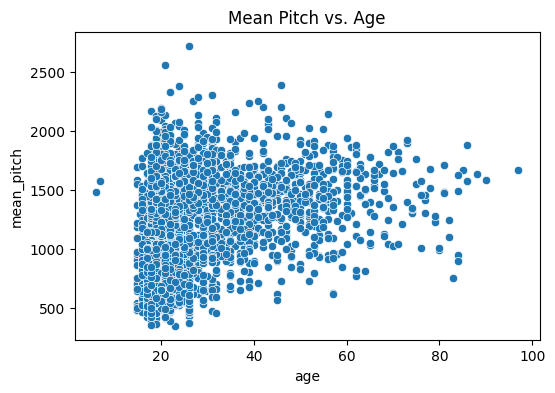

In [182]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="mean_pitch", data=development_data)
plt.title("Mean Pitch vs. Age")
plt.show()

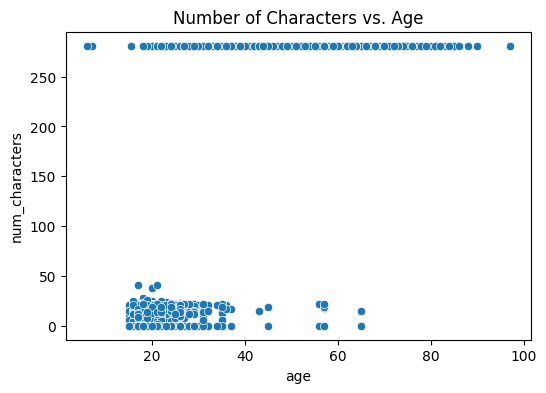

In [183]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="num_characters", data=development_data)
plt.title("Number of Characters vs. Age")
plt.show()

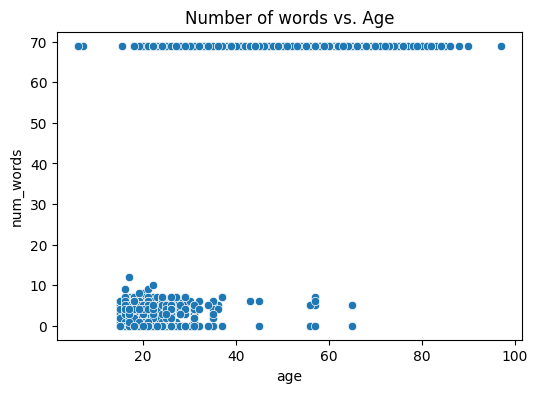

In [184]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="num_words", data=development_data)
plt.title("Number of words vs. Age")
plt.show()

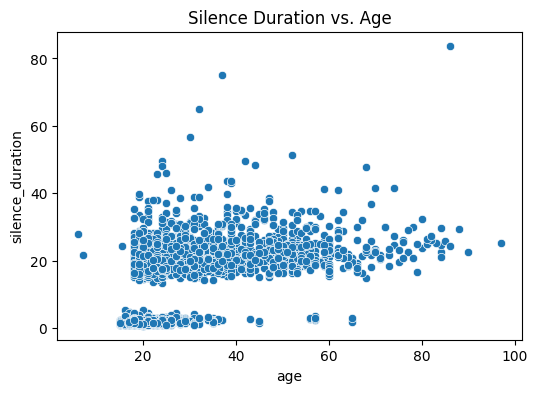

In [185]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="silence_duration", data=development_data)
plt.title("Silence Duration vs. Age")
plt.show()

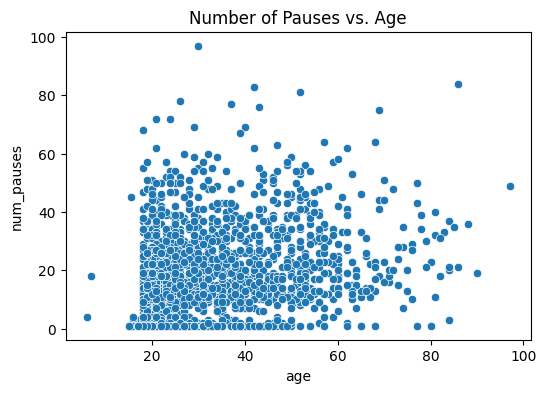

In [186]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="age", y="num_pauses", data=development_data)
plt.title("Number of Pauses vs. Age")
plt.show()

In [187]:
print(evaluation_data.info())
print(evaluation_data.describe())

# Check for columns that might differ from development
missing_eval = evaluation_data.isnull().sum()
print("Missing in evaluation:\n", missing_eval)

unique_genders_eval = evaluation_data["gender"].unique()
print("Evaluation genders:", unique_genders_eval)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      691 non-null    int64  
 1   sampling_rate           691 non-null    int64  
 2   gender                  691 non-null    object 
 3   ethnicity               691 non-null    object 
 4   mean_pitch              691 non-null    float64
 5   max_pitch               691 non-null    float64
 6   min_pitch               691 non-null    float64
 7   jitter                  691 non-null    float64
 8   shimmer                 691 non-null    float64
 9   energy                  691 non-null    float64
 10  zcr_mean                691 non-null    float64
 11  spectral_centroid_mean  691 non-null    float64
 12  tempo                   691 non-null    object 
 13  hnr                     691 non-null    float64
 14  num_words               691 non-null    in

In [188]:
evaluation_data["tempo"] = evaluation_data["tempo"].apply(parse_tempo)
evaluation_data['gender'] = evaluation_data['gender'].replace({'famale': 'female'})

In [189]:
# 1. Identify top 1 most frequent ethnicities
top_1 = evaluation_data['ethnicity'].value_counts().nlargest(1).index

# 2. Replace everything not in top_1 with "Other"
evaluation_data['ethnicity'] = evaluation_data['ethnicity'].apply(
    lambda x: x if x in top_1 else "Other"
)

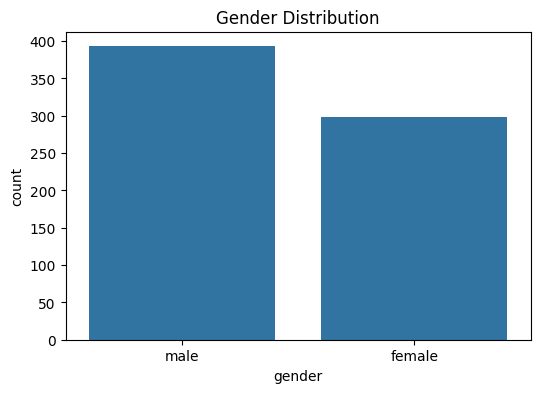

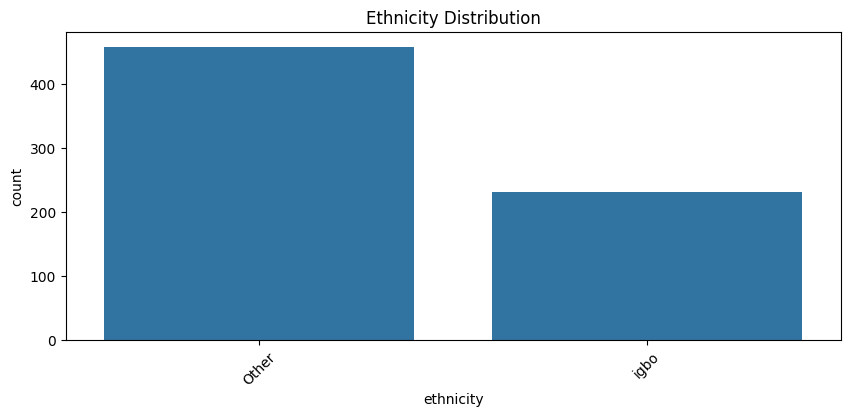

In [190]:
# Countplot for gender
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=evaluation_data)
plt.title("Gender Distribution")
plt.show()

# Countplot for ethnicity
plt.figure(figsize=(10,4))
sns.countplot(x="ethnicity", data=evaluation_data,
              order=evaluation_data["ethnicity"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Ethnicity Distribution")
plt.show()